Purpose of this notebook is to setup a simple VAE that can learn poses of cubes.

@yvan june 9 2018

Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torch.autograd import Variable
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms import transforms

In [2]:
# constants
NEPOCHS = 100
BATCH_SIZE = 64
SEED = 1337
IMG_DIM = 64
ncpus = !nproc
NCPUS = int(ncpus[0])
IMG_PATH = '/home/yvan/data_load/imgs_jpg_clpr_128/'

In [3]:
torch.cuda.is_available(), torch.__version__, torch.cuda.device_count(), torch.cuda.device(0)

(True, '0.4.0', 2, <torch.cuda.device at 0x7ffb282d8978>)

In [4]:
t = transforms.Compose([transforms.ToTensor()])
cube_dataset = ImageFolder(IMG_PATH, transform=t)
cube_loader = data.DataLoader(dataset=cube_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NCPUS)

Create a simple VAE model.

In [32]:
# thanks to https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/Variational_autoencoder.py
# for his implementation of a simple VAE
class Vae(nn.Module):
    def __init__(self):
        super(Vae,self).__init__()
        # encoder dense layers
        self.dense1 = nn.Linear(3*IMG_DIM*IMG_DIM, int(IMG_DIM*IMG_DIM/50))
        # two output vectors, one for mu, and one for log variance.
        self.dense11 = nn.Linear(int(IMG_DIM*IMG_DIM/50), 10)
        self.dense12 = nn.Linear(int(IMG_DIM*IMG_DIM/50), 10)
        # decoder dense layers
        self.dense3 = nn.Linear(10, int(IMG_DIM*IMG_DIM/50))
        self.dense4 = nn.Linear(int(IMG_DIM*IMG_DIM/50), IMG_DIM*IMG_DIM*3)
        
    def encode(self, x):
        x = F.relu(self.dense1(x))
        return self.dense11(x), self.dense12(x)
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            epsilon = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            epsilon = torch.FloatTensor(std.size()).normal_()
        epsilon = Variable(epsilon)
        return epsilon.mul(std).add(mu)
    
    def decode(self, x):
        x = F.relu(self.dense3(x))
        return F.sigmoid(self.dense4(x))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_func(reconstructed, original, mu, logvar):
    mse = nn.MSELoss(size_average=False)(reconstructed, original)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kld

In [33]:
model = Vae()
if torch.cuda.is_available():
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(NEPOCHS):
    model.train()
    for i, batch in enumerate(cube_loader):
        # get and flatten img, move to gpu
        img, _ = batch
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        # run our vae
        reconstructed_batch, mu, logvar = model(img)
        loss = loss_func(reconstructed_batch, img, mu, logvar)
        # backprop the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch{epoch}:{loss.item()}')

epoch0:19804.23828125
epoch1:16698.8984375
epoch2:15130.6015625
epoch3:13670.236328125
epoch4:13355.34375
epoch5:12591.724609375
epoch6:12609.861328125
epoch7:13329.27734375
epoch8:12087.1884765625
epoch9:12049.68359375
epoch10:12242.1123046875
epoch11:11638.37109375
epoch12:11970.3701171875
epoch13:11318.2529296875
epoch14:11459.5009765625
epoch15:11120.8935546875
epoch16:11391.1904296875
epoch17:11180.8203125
epoch18:11159.005859375
epoch19:11061.591796875
epoch20:11014.83203125
epoch21:10786.8291015625
epoch22:10846.228515625
epoch23:10954.8388671875
epoch24:10471.578125
epoch25:11554.9345703125
epoch26:10748.1904296875
epoch27:10363.3828125
epoch28:10512.6201171875
epoch29:10457.2177734375
epoch30:10430.509765625
epoch31:10794.15625
epoch32:10582.2939453125
epoch33:10323.33203125
epoch34:10136.208984375
epoch35:10353.76953125
epoch36:10270.2822265625
epoch37:10035.7060546875
epoch38:9923.4921875
epoch39:10172.919921875
epoch40:10082.3974609375
epoch41:9983.8310546875
epoch42:10019.

In [35]:
model.eval()
sample = torch.randn(64, 10).cuda()
sample = model.decode(sample).cpu()

In [36]:
firstimg = sample.view(64, 3, 64, 64)

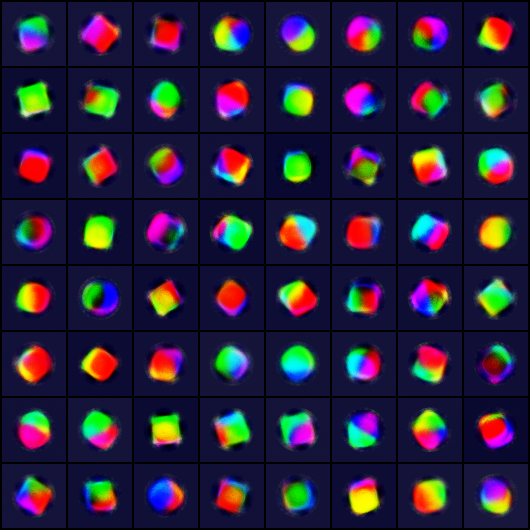

In [37]:
grid = make_grid(firstimg)
grid = transforms.Compose([transforms.ToPILImage()])(grid)
grid

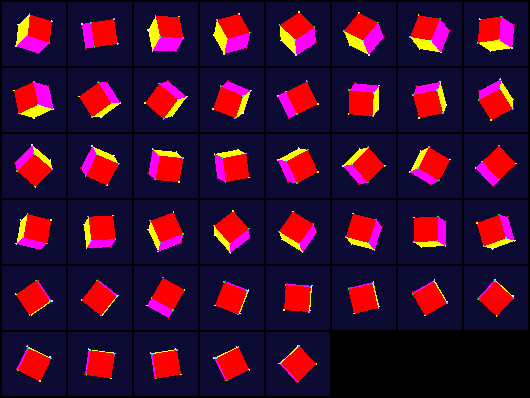

In [38]:
imggrid = make_grid(batch[0])
imggrid = transforms.Compose([transforms.ToPILImage()])(imggrid)
imggrid